In [ ]:
# The idea of this notebook is to have a look at what is actually going on with the states and if predictions make sense

In [20]:
import pandas as pd
from chess_ai.rlagent.muzero.utils import MOVES, encode_state
from chess_ai.rlagent.muzero.models import AlphazeroNetSupervised
from chess_ai.rlagent.muzero.utils import get_root_dir
import torch
import numpy as np
from chess_python.chess import Chess
from pathlib import Path
import matplotlib.pyplot as plt

# check if the model is training

In [2]:
buffer = pd.read_feather(Path("../") /"chess_ai"/ "rlagent" / "data" / "dataframe" / f"buffer_df.feather").head(100)

In [3]:
buffer["hash_state"] = buffer.state.apply(lambda x: hash(tuple(x)))

In [4]:
buffer.hash_state.value_counts()

-6989483368135847075    2
 7625831177009475824    2
 6771074615988671364    1
-4401184605338239325    1
-245003916721018551     1
                       ..
-6762146233494102993    1
-3084281351645450727    1
 5419084124687063762    1
 5658772475041677070    1
-5274813546898329798    1
Name: hash_state, Length: 98, dtype: int64

In [11]:
hash_state =  -6989483368135847075 

In [12]:
buffer["hash_state"]

0    -6989483368135847075
1     7625831177009475824
2     6687996695591878318
3     2503667552372949105
4    -5268376159039734197
             ...         
95    2771047007373265474
96   -4208710992922328479
97    4060774543361799284
98    8550296491066223543
99   -5274813546898329798
Name: hash_state, Length: 100, dtype: int64

In [13]:
x = torch.tensor(np.stack(buffer.state.values, axis=0), dtype=torch.float32)
#x = torch.tensor(buffer[buffer.hash_state==hash_state].iloc[0].state, dtype=torch.float32).view(-1,67)

In [33]:
model = AlphazeroNetSupervised()
model.load_state_dict(torch.load("../chess_ai/rlagent/checkpoints/nn_supervised_conv_20.pth"))
model.eval()

AlphazeroNetSupervised(
  (c1): Conv1d(1, 20, kernel_size=(3,), stride=(1,))
  (l1): Linear(in_features=1300, out_features=1, bias=True)
  (l2): Linear(in_features=1300, out_features=4208, bias=True)
  (activation): Tanh()
)

In [31]:
print(buffer[buffer.hash_state==hash_state].iloc[0].value)
value, policy = model(x)
#print(value)

0.025494474312226956


In [32]:
#plt.plot(value.detach().numpy(), buffer.value, ".")

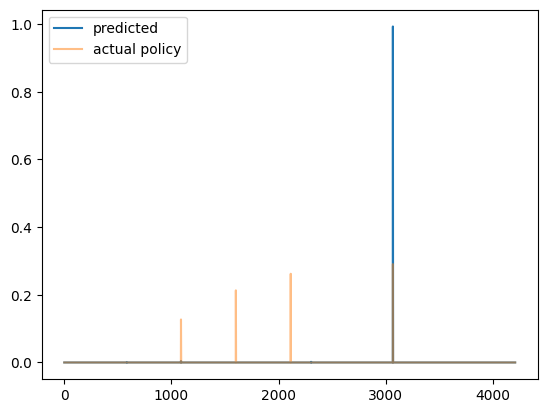

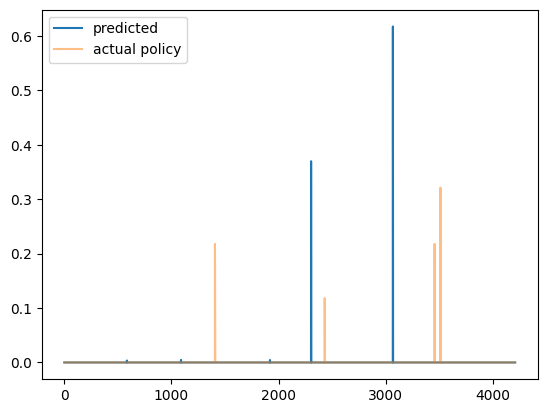

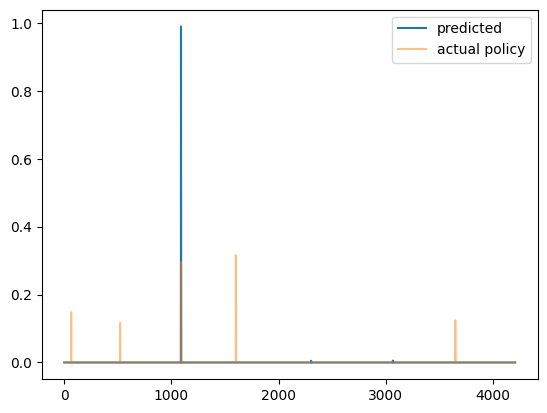

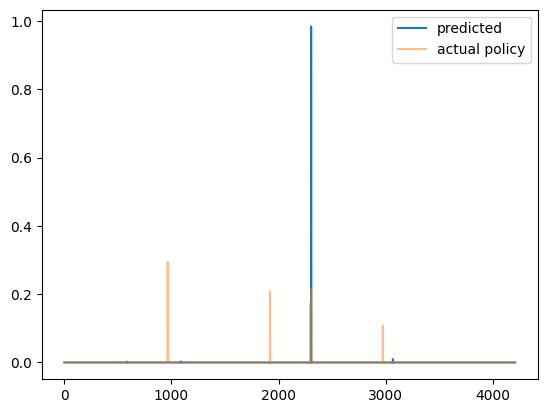

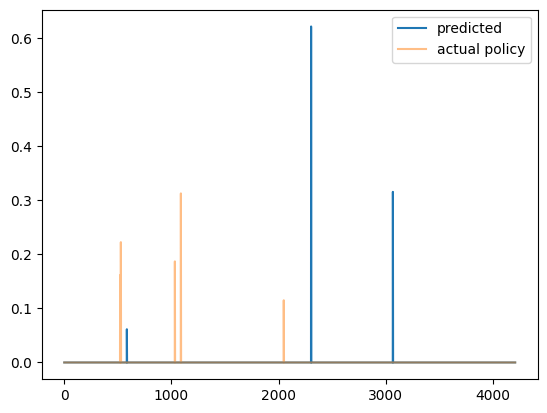

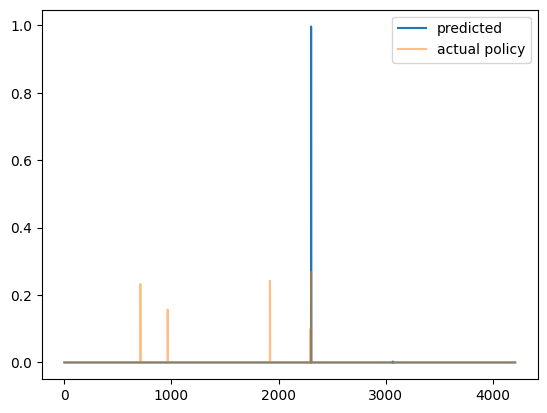

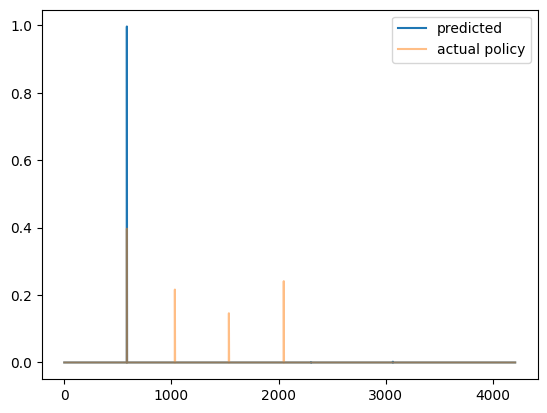

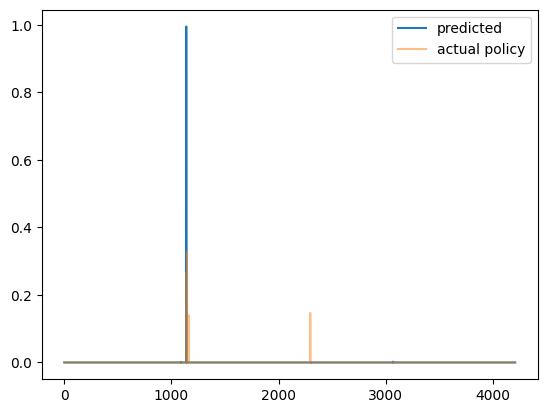

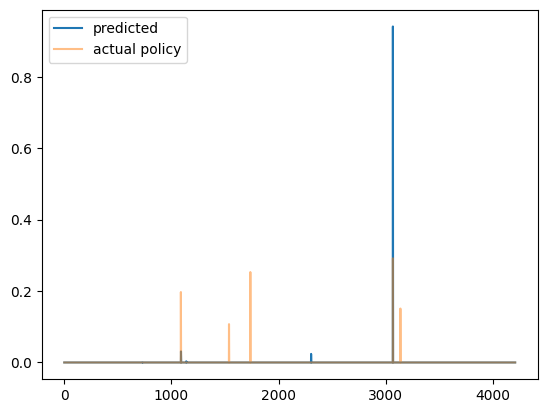

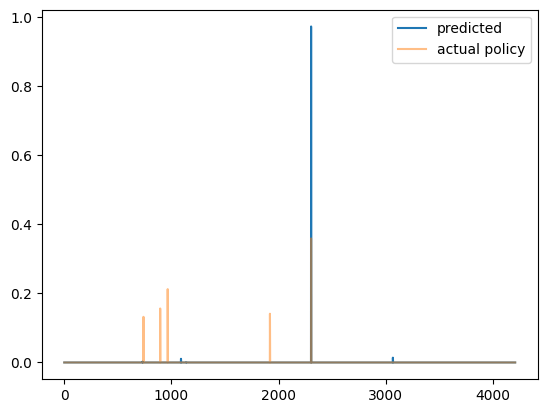

In [34]:
for i in range(10):
    plt.plot(policy[i].detach().numpy(), label="predicted")
    plt.plot(buffer.iloc[i].policy, alpha=0.5, label="actual policy")
    plt.legend()
    plt.show()

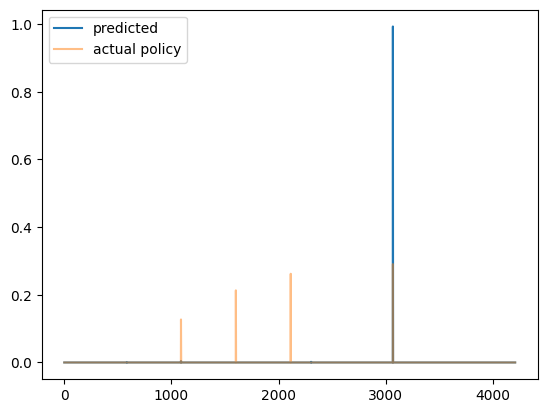

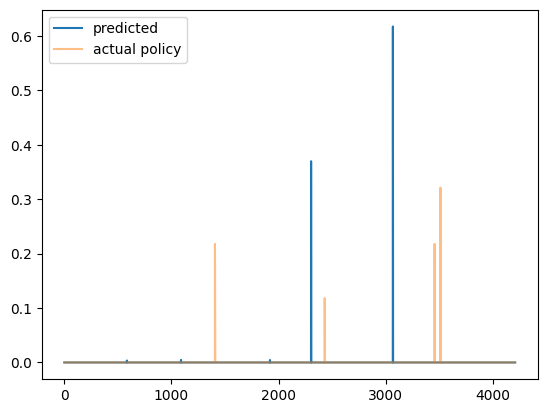

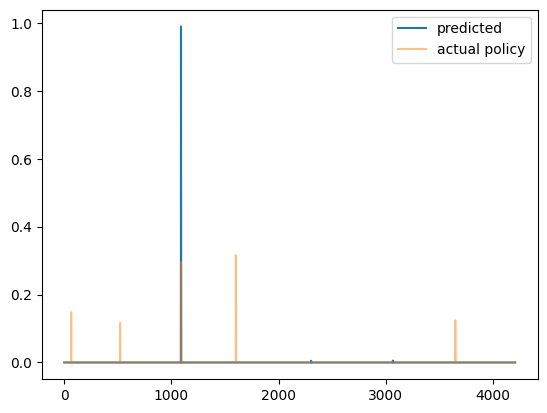

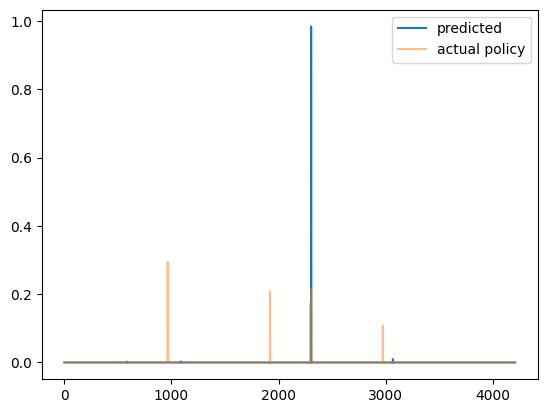

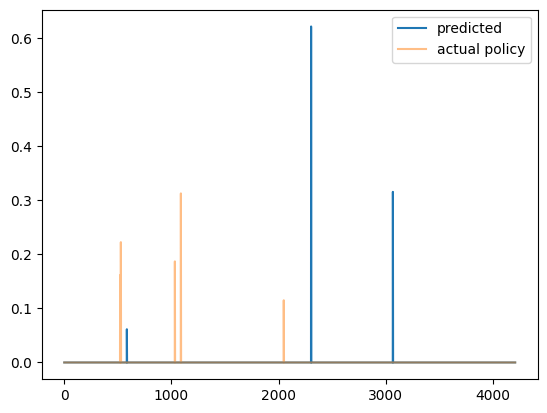

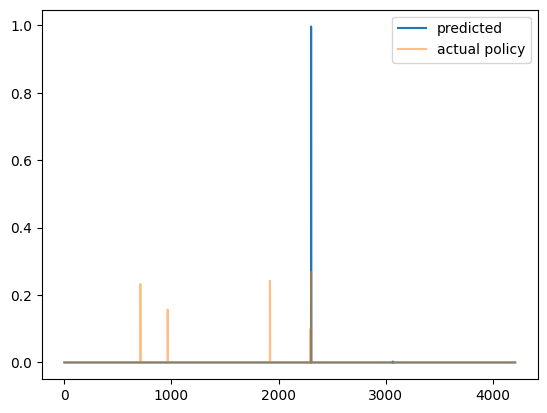

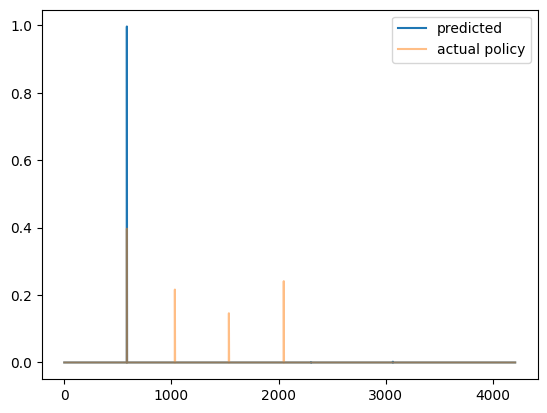

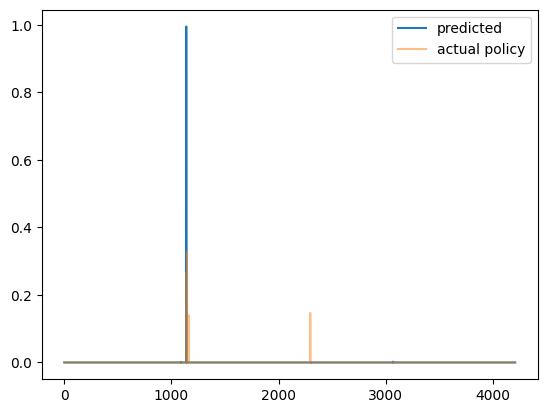

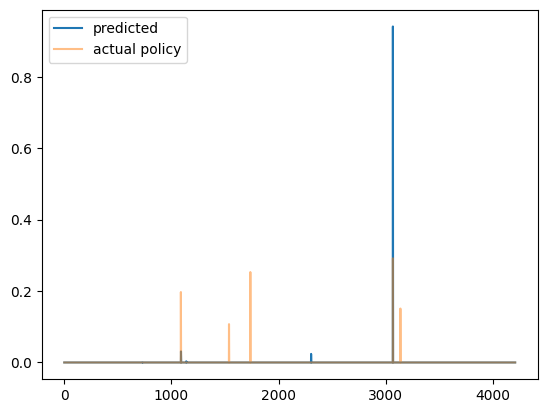

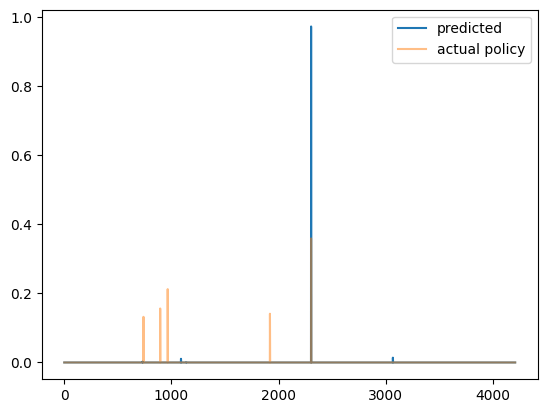

In [30]:
for i in range(10):
    plt.plot(policy[i].detach().numpy(), label="predicted")
    plt.plot(buffer.iloc[i].policy, alpha=0.5, label="actual policy")
    plt.legend()
    plt.show()

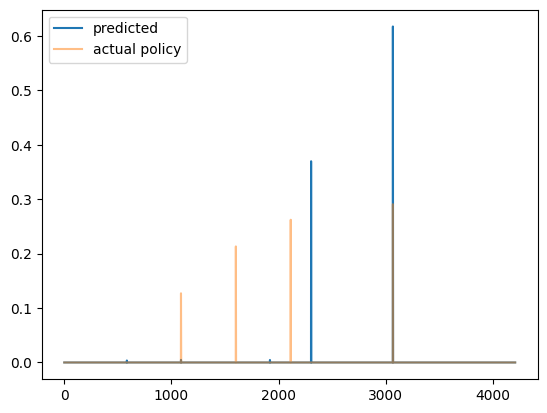

In [26]:
plt.plot(policy[1].detach().numpy(), label="predicted")
plt.plot(buffer[buffer.hash_state==hash_state].iloc[0].policy, alpha=0.5, label="actual policy")
plt.legend()

0.0002376425855513308
0.0002376425855513308


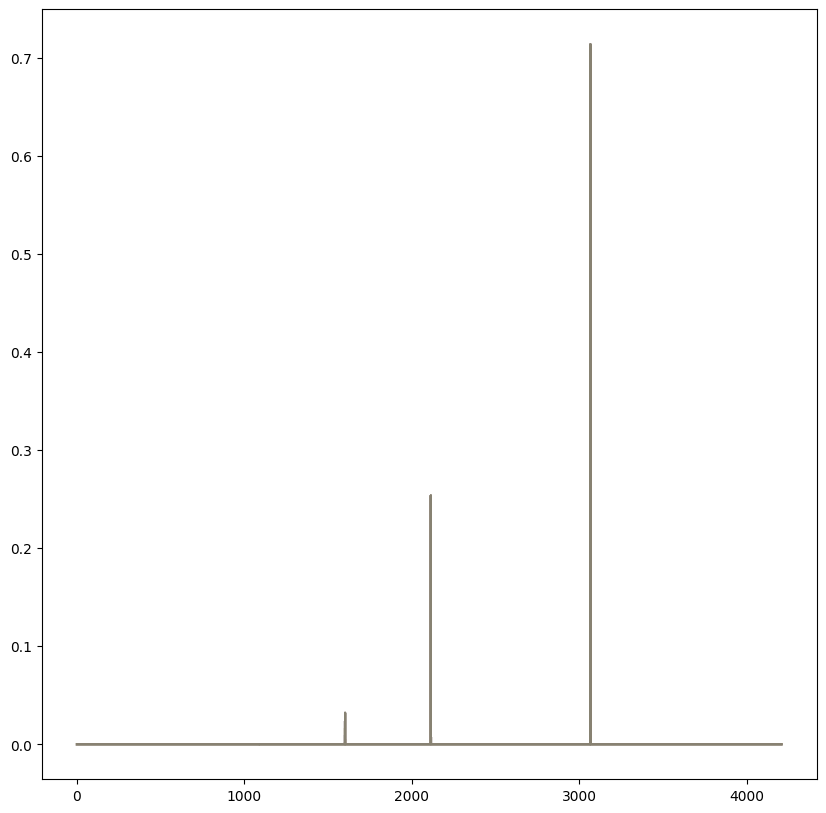

In [117]:
plt.figure(figsize=(10,10))
list_mean = []
for i in range(40):
    plt.plot(buffer[buffer.hash_state==hash_state].iloc[i].policy, alpha=0.1)
    #print(buffer[buffer.hash_state==hash_state].iloc[i].value)
    list_mean.append(buffer[buffer.hash_state==hash_state].iloc[i].policy.mean())
print(max(list_mean))
print(min(list_mean))


In [89]:
import os
os.getcwd()

'/Users/pablocanadapereira/Desktop/Projects/chess-ai/notebooks'

In [90]:

buffer = pd.read_feather(Path("../") /"chess_ai"/ "rlagent" / "data" / "dataframe" / f"buffer_df.feather")


In [91]:
df = buffer

In [92]:
#df = pd.read_feather("../supervised_dataset_2.feather")

In [93]:
#df["value"] = 1/(1+np.exp(-0.01*df.evaluation))

In [94]:
df.value.min()

-0.9994563063989771

In [95]:
first_move = df.iloc[0].move
print(first_move)

b1c3


In [96]:
df.iloc[1].state, df.iloc[1].value

(array([ 4,  0,  3,  5,  6,  3,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,  0,
         0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,
        -1, -1, -1, -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1,  0, 15]),
 0.005499944542337598)

In [108]:
df.iloc[3]

level_0                                                           3
index                                                           0_4
moves                                [d7d5, g8f6, c7c5, b8c6, a7a6]
move                                                           a7a6
state             [4, 0, 3, 5, 6, 3, 2, 4, 0, 1, 1, 1, 1, 1, 1, ...
fen               rnbqkbnr/pppp1ppp/4p3/8/8/P1N5/1PPPPPPP/R1BQKB...
scores_number                                 [15, 8, -5, -49, -35]
scores_softmax    [0.7249817734546079, 0.24283847599286498, 0.03...
value_number                                                     15
value                                                        0.0075
policy            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 3, dtype: object

In [97]:
pol = df.iloc[1].policy

In [98]:
pol.max()

0.9988281380226485

In [99]:
MOVES[df.iloc[1].policy.argmax()]

'd7d5'

In [100]:
model = AlphazeroNetSupervised()
model.load_state_dict(torch.load("../chess_ai/rlagent/checkpoints/nn_supervised.pth"))
model.eval()

AlphazeroNetSupervised(
  (l1): Linear(in_features=67, out_features=200, bias=True)
  (l2): Linear(in_features=200, out_features=1, bias=True)
  (l3): Linear(in_features=200, out_features=4208, bias=True)
  (activation): Tanh()
)

In [101]:
torch.tensor(df.iloc[1].state).view(-1,67)

tensor([[ 4,  0,  3,  5,  6,  3,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
          2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1,
         -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1,  0, 15]])

In [102]:
print(encode_state(Chess().move(first_move).state))

[4, 0, 3, 5, 6, 3, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1, 0, 15]


In [103]:
value_pred_train, policy_pred_train = model(torch.tensor(df.iloc[1].state, dtype=torch.float32).view(-1,67))
value_pred, policy_pred = model(torch.tensor(encode_state(Chess().move(first_move).state), dtype=torch.float32).view(-1, 67))

In [104]:
print(value_pred_train, policy_pred_train)
print("Net pred", value_pred, policy_pred)

tensor([[-0.0364]], grad_fn=<TanhBackward0>) tensor([[2.8517e-12, 2.2832e-09, 2.8517e-12,  ..., 2.8517e-12, 2.8517e-12,
         2.8517e-12]], grad_fn=<SoftmaxBackward0>)
Net pred tensor([[-0.0364]], grad_fn=<TanhBackward0>) tensor([[2.8517e-12, 2.2832e-09, 2.8517e-12,  ..., 2.8517e-12, 2.8517e-12,
         2.8517e-12]], grad_fn=<SoftmaxBackward0>)


In [81]:
MOVES[policy_pred.argmax().detach().numpy()]

'd7d5'